# Rational Exponent as Speed Bottleneck in Dynamic Asset Problems

Rational exponentiation is perhaps one of the core computational tasks in solving any dynamic models. 

It turns out, in solving a model with CRRA utility for example, the vast majority of computing time might be spent on the single task of exponentiating to a rational number.

When the exponentiation is integer based, things are quicker. Whether integer or not, exponents are dramatically more time consuming to compute than addition subtraction etc. 

For fully grid based solution algorithm, since maximization is almost instantaneous, the computing burden falls disproportionately on the exponentiation of potentially very large gridded matrixes. 

If one could compute $x^\rho$ y percent faster, that almost leads to y percent (linear) improvements in overall computing time. 

So how do we improve exponentiation time?

Well, regardless of the number of choices you have, consumption at the end, in the standard problem, enters under the rational exponent by itself. So we have a one dimensional problem. 

Imagine that we are to evaluate a 1 million (endo states) by 15 (exo shocks) matrix of consumption values, how do we make this go faster?

There is a wide variety of ways potentially. The method explored here is through 1d interpolation, which is can be extremely accurate given that we know the analytical solution to $x^\rho$. This is a trivial interpolation problem compared to interpolating over Value or Policy functions given high dimensional state space. 

In fact, we face a potential interpolation tradeoff:

1. we could solve a problem with a small set of grid points and interpolate over the value function approximations, this has low memory burden but relies more on approximation.
2. we could alternatively use very dense grids and interpolate within period utility function, this has high memory burden but is potentially more accurate.

Both paths could be equally fast. 

Here, this problem and interpolation solution is demonstrated in the context of Matlab relevant for the second route. 

## The Problem

In [422]:
clear all;
st_single_double = 'double';
bl_show_fig = true;
z = 15;
iter = 50;

it_rown = 500 % 4GB if 1000
it_coln = round(((it_rown-1)*it_rown)/2 + it_rown);

c_min = 0.001;
c_min_for_util = 0.001;
c_gap = 10^-3;
c_max = 60;
tic;
mt_c = rand([it_rown*it_coln,1])*(c_max - c_min) + c_min;
mt_c = sort(mt_c);

if (strcmp(st_single_double, 'single'))
    mt_c = single(mt_c);
end
toc;


it_rown =

   500

Elapsed time is 2.118147 seconds.



In [423]:
whos

  Name                         Size                Bytes  Class      Attributes

  bl_show_fig                  1x1                     1  logical              
  c_gap                        1x1                     8  double               
  c_max                        1x1                     8  double               
  c_min                        1x1                     8  double               
  c_min_for_util               1x1                     8  double               
  it_coln                      1x1                     8  double               
  it_rown                      1x1                     8  double               
  iter                         1x1                     8  double               
  mt_c                  62625000x1             501000000  double               
  st_single_double             1x6                    12  char                 
  z                            1x1                     8  double               




In [424]:
% Define Function Handle
fl_crra = 1.5;
if (strcmp(st_single_double, 'single'))
    fl_crra = single(fl_crra);
end
fu_c = @(c) (((c).^(1-fl_crra)-1)./(1-fl_crra));
fu_c_fixed = @() (fu_c(mt_c).*(mt_c > c_min_for_util) + ...
                  fu_c(c_min_for_util).*(mt_c <= c_min_for_util)) ;

In [425]:
% Compute Time Cost
fl_t_direct_eval = timeit(fu_c_fixed);
ar_fl_compute_t(1) = fl_t_direct_eval;
ar_cl_method_names{1} = 'Direct Evaluation';

## Pre-Compute and Interpolate

Suppose we are interested in $c^\rho$, where $\rho$ is possibly a fraction.

In [426]:
% C array
fl_mt_c_min = min(mt_c, [], 'all');
fl_mt_c_max = max(mt_c, [], 'all');
it_max_n = (fl_mt_c_max-fl_mt_c_min)/(c_gap);
it_interp_points = min(it_rown*it_coln, it_max_n)


it_interp_points =

   5.9999e+04




In [427]:
it_interp_c_grid_n = min(it_rown*it_coln, it_max_n);
ar_fl_c_grid = linspace(fl_mt_c_min, fl_mt_c_max, it_interp_c_grid_n);
if (strcmp(st_single_double, 'single'))
    ar_fl_c_grid = single(ar_fl_c_grid);
end
fl_ar_c_grid_gap = ar_fl_c_grid(2) - ar_fl_c_grid(1);
disp(length(ar_fl_c_grid))
disp(ar_fl_c_grid(2) - ar_fl_c_grid(1))

       59998

    0.0010




In [428]:
% Evaluate
ar_fl_u_at_c_grid = fu_c(ar_fl_c_grid);
% Dealing with Minimum Consumption Threshold
mt_it_c_valid_idx = (ar_fl_c_grid <= c_min_for_util);
fl_u_neg_c = fu_c(c_min_for_util);
ar_fl_u_at_c_grid(mt_it_c_valid_idx) = fl_u_neg_c;

## Interpolate Method 1a--interp1d non-default grid

In [429]:
% Interpolation Evaluator
fu_interp_near_c_fixed = @() interp1(ar_fl_c_grid, ar_fl_u_at_c_grid, mt_c, 'nearest');
fu_interp_linr_c_fixed = @() interp1(ar_fl_c_grid, ar_fl_u_at_c_grid, mt_c, 'linear');

In [430]:
% Compute Time Cost
fl_time_interp_near = timeit(fu_interp_near_c_fixed);
disp(fl_time_interp_near)
disp(fl_time_interp_near*z*iter)
ar_fl_compute_t(2) = fl_time_interp_near;
ar_cl_method_names{2} = 'interp1d nearest';

    0.2128

  159.5850




In [431]:
fl_time_interp_linr = timeit(fu_interp_linr_c_fixed);
disp(fl_time_interp_linr)
disp(fl_time_interp_linr*z*iter)
ar_fl_compute_t(3) = fl_time_interp_linr;
ar_cl_method_names{3} = 'interp1d linear';

    0.2132

  159.8937




## Interpolate Method 1b--interp1d integer default grid

In [432]:
% Interpolation Evaluator
fu_interp_near_dflt = @() interp1(ar_fl_u_at_c_grid, (((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1), 'nearest');
fu_interp_linr_dflt = @() interp1(ar_fl_u_at_c_grid, (((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1), 'linear');

In [433]:
% Compute Time Cost
fl_time_interp_near_dflt = timeit(fu_interp_near_dflt);
disp(fl_time_interp_near_dflt)
disp(fl_time_interp_near_dflt*z*iter)
ar_fl_compute_t(4) = fl_time_interp_near_dflt;
ar_cl_method_names{4} = 'interp1d nearest default grid';

    0.3853

  288.9731




In [434]:
fl_time_interp_linr_dflt = timeit(fu_interp_linr_dflt);
disp(fl_time_interp_linr_dflt)
disp(fl_time_interp_linr_dflt*z*iter)
ar_fl_compute_t(5) = fl_time_interp_linr_dflt;
ar_cl_method_names{5} = 'interp1d linear default grid';

    0.3770

  282.7762




## Interpolate Method 2a--Index based Interpolation find index first

In [435]:
% Get Quotient
fix((mt_c-min(mt_c, [], 'all'))./fl_ar_c_grid_gap) + 1;
fl_mt_c_min = min(mt_c, [], 'all');

In [436]:
f_divide = @() (((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);
fl_time_divide = timeit(f_divide);
disp(fl_time_divide)
disp(fl_time_divide*z*iter)
ar_fl_compute_t(6) = fl_time_divide;
ar_cl_method_names{6} = 'fan index divide integer';

    0.3476

  260.6644




In [437]:
f_round = @() (fix((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);
fl_time_round = timeit(f_round);
disp(fl_time_round)
disp(fl_time_round*z*iter)
ar_fl_compute_t(7) = fl_time_round;
ar_cl_method_names{7} = 'fan index round integer';

    0.3432

  257.3868




In [438]:
fu_interp_near_c_idx_fixed = @() ar_fl_u_at_c_grid(fix((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);
fu_interp_near_c_rnd_fixed = @() ar_fl_u_at_c_grid(round((mt_c-fl_mt_c_min)./fl_ar_c_grid_gap) + 1);

In [439]:
% Compute Time Cost
fl_time_interp_near_idx = timeit(fu_interp_near_c_idx_fixed);
disp(fl_time_interp_near_idx)
disp(fl_time_interp_near_idx*z*iter)
ar_fl_compute_t(8) = fl_time_interp_near_idx;
ar_cl_method_names{8} = 'fan index interp fix';

    0.8153

  611.4404




In [440]:
% Compute Time Cost
fl_time_interp_near_rnd = timeit(fu_interp_near_c_rnd_fixed);
disp(fl_time_interp_near_rnd)
disp(fl_time_interp_near_rnd*z*iter)
ar_fl_compute_t(9) = fl_time_interp_near_idx;
ar_cl_method_names{9} = 'fan index interp round';

    0.8168

  612.5810




## Interpolate Method 2b--Index based Interpolation Default Grid Index

In [441]:
fu_interp_near_c_rnd_dflt = @() ar_fl_u_at_c_grid(round(mt_c - min(mt_c))+1);

In [442]:
% Compute Time Cost
fl_time_interp_rnd_dflt = timeit(fu_interp_near_c_rnd_dflt);
disp(fl_time_interp_rnd_dflt)
disp(fl_time_interp_rnd_dflt*z*iter)
ar_fl_compute_t(10) = fl_time_interp_rnd_dflt;
ar_cl_method_names{10} = 'fan index interp round default grid';

    0.8443

  633.2436




## Interpolate Method 3--griddedInterpolant (introduced since matlab R2011b)

In [443]:
% Generate Interpolant
f_grid_interpolant_near = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid, 'nearest')
f_grid_interpolant_linr = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid, 'linear')
f_grid_interpolant_spln = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid, 'spline')

% Interpolation Evaluator
fu_interp_gridded_near = @() f_grid_interpolant_near(mt_c);
fu_interp_gridded_linr = @() f_grid_interpolant_linr(mt_c);
fu_interp_gridded_spln = @() f_grid_interpolant_spln(mt_c);


f_grid_interpolant_near = 

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [1x59998 double]
                 Method: 'nearest'
    ExtrapolationMethod: 'nearest'


f_grid_interpolant_linr = 

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [1x59998 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'


f_grid_interpolant_spln = 

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [1x59998 double]
                 Method: 'spline'
    ExtrapolationMethod: 'spline'




In [444]:
% Compute Time Cost
fl_time_gridded_near = timeit(fu_interp_gridded_near);
disp(fl_time_gridded_near)
disp(fl_time_gridded_near*z*iter)
ar_fl_compute_t(11) = fl_time_gridded_near;
ar_cl_method_names{11} = 'griddedInterpolant nearest';

    0.1640

  123.0142




In [445]:
% Compute Time Cost
fl_time_gridded_linr = timeit(fu_interp_gridded_linr);
disp(fl_time_gridded_linr)
disp(fl_time_gridded_linr*z*iter)
ar_fl_compute_t(12) = fl_time_gridded_linr;
ar_cl_method_names{12} = 'griddedInterpolant linear';

    0.1666

  124.9682




In [446]:
% Compute Time Cost
fl_time_gridded_spln = timeit(fu_interp_gridded_spln);
disp(fl_time_gridded_spln)
disp(fl_time_gridded_spln*z*iter)
ar_fl_compute_t(13) = fl_time_gridded_spln;
ar_cl_method_names{13} = 'griddedInterpolant spline';

    0.1653

  123.9980




## Interpolation Method 4 splinterp1

This is from [apryor6/splinterp](https://github.com/apryor6/splinterp), mex file from c. 

In [447]:
% Load Packages
rmpath(genpath('C:/Users/fan/M4Econ/external/splinterp/'))
addpath(genpath('C:/Users/fan/M4Econ/external/splinterp/'))

In [448]:
% Interpolation Evaluator
if (strcmp(st_single_double, 'single'))
    %     can not run splinterp if single
else
    fu_splinterp_fixed = @() splinterp1(ar_fl_u_at_c_grid, mt_c(:));
    % Compute Time Cost
    fl_time_splinterp = timeit(fu_splinterp_fixed);
    disp(fl_time_splinterp)
    disp(fl_time_splinterp*z*iter)
    ar_fl_compute_t(14) = fl_time_splinterp;
    ar_cl_method_names{14} = 'splinterp default grid';    
end

    0.2183

  163.7584




In [449]:
% Interpolation Evaluator
if (strcmp(st_single_double, 'single'))
    %     can not run splinterp if single
else
    fu_splinterp_dvd = @() splinterp1(ar_fl_u_at_c_grid, (((mt_c(:)-fl_mt_c_min)./fl_ar_c_grid_gap) + 1));
    % Compute Time Cost
    fl_time_splinterp_dvd = timeit(fu_splinterp_dvd);
    disp(fl_time_splinterp_dvd)
    disp(fl_time_splinterp_dvd*z*iter)
    ar_fl_compute_t(15) = fl_time_splinterp_dvd;
    ar_cl_method_names{15} = 'splinterp default grid c/divide';
end

    0.3827

  287.0363




## Interpolation Results, Speed Comparison

In [450]:
tb_fl_compute_t = array2table([ar_fl_compute_t', ar_fl_compute_t'*z*iter]);
tb_fl_compute_t.Properties.RowNames = ar_cl_method_names;
tb_fl_compute_t.Properties.VariableNames = {'speedmat', 'speedfull'};
disp(tb_fl_compute_t);

                                           speedmat    speedfull
                                           ________    _________

    Direct Evaluation                       1.7156      1286.7  
    interp1d nearest                       0.21278      159.59  
    interp1d linear                        0.21319      159.89  
    interp1d nearest default grid           0.3853      288.97  
    interp1d linear default grid           0.37703      282.78  
    fan index divide integer               0.34755      260.66  
    fan index round integer                0.34318      257.39  
    fan index interp fix                   0.81525      611.44  
    fan index interp round                 0.81525      611.44  
    fan index interp round default grid    0.84432      633.24  
    griddedInterpolant nearest             0.16402      123.01  
    griddedInterpolant linear              0.16662      124.97  
    griddedInterpolant spline              0.16533         124  
    splinterp default gr

### griddedInterpolant graphing

In [451]:
% fl_fu_c_fixed'

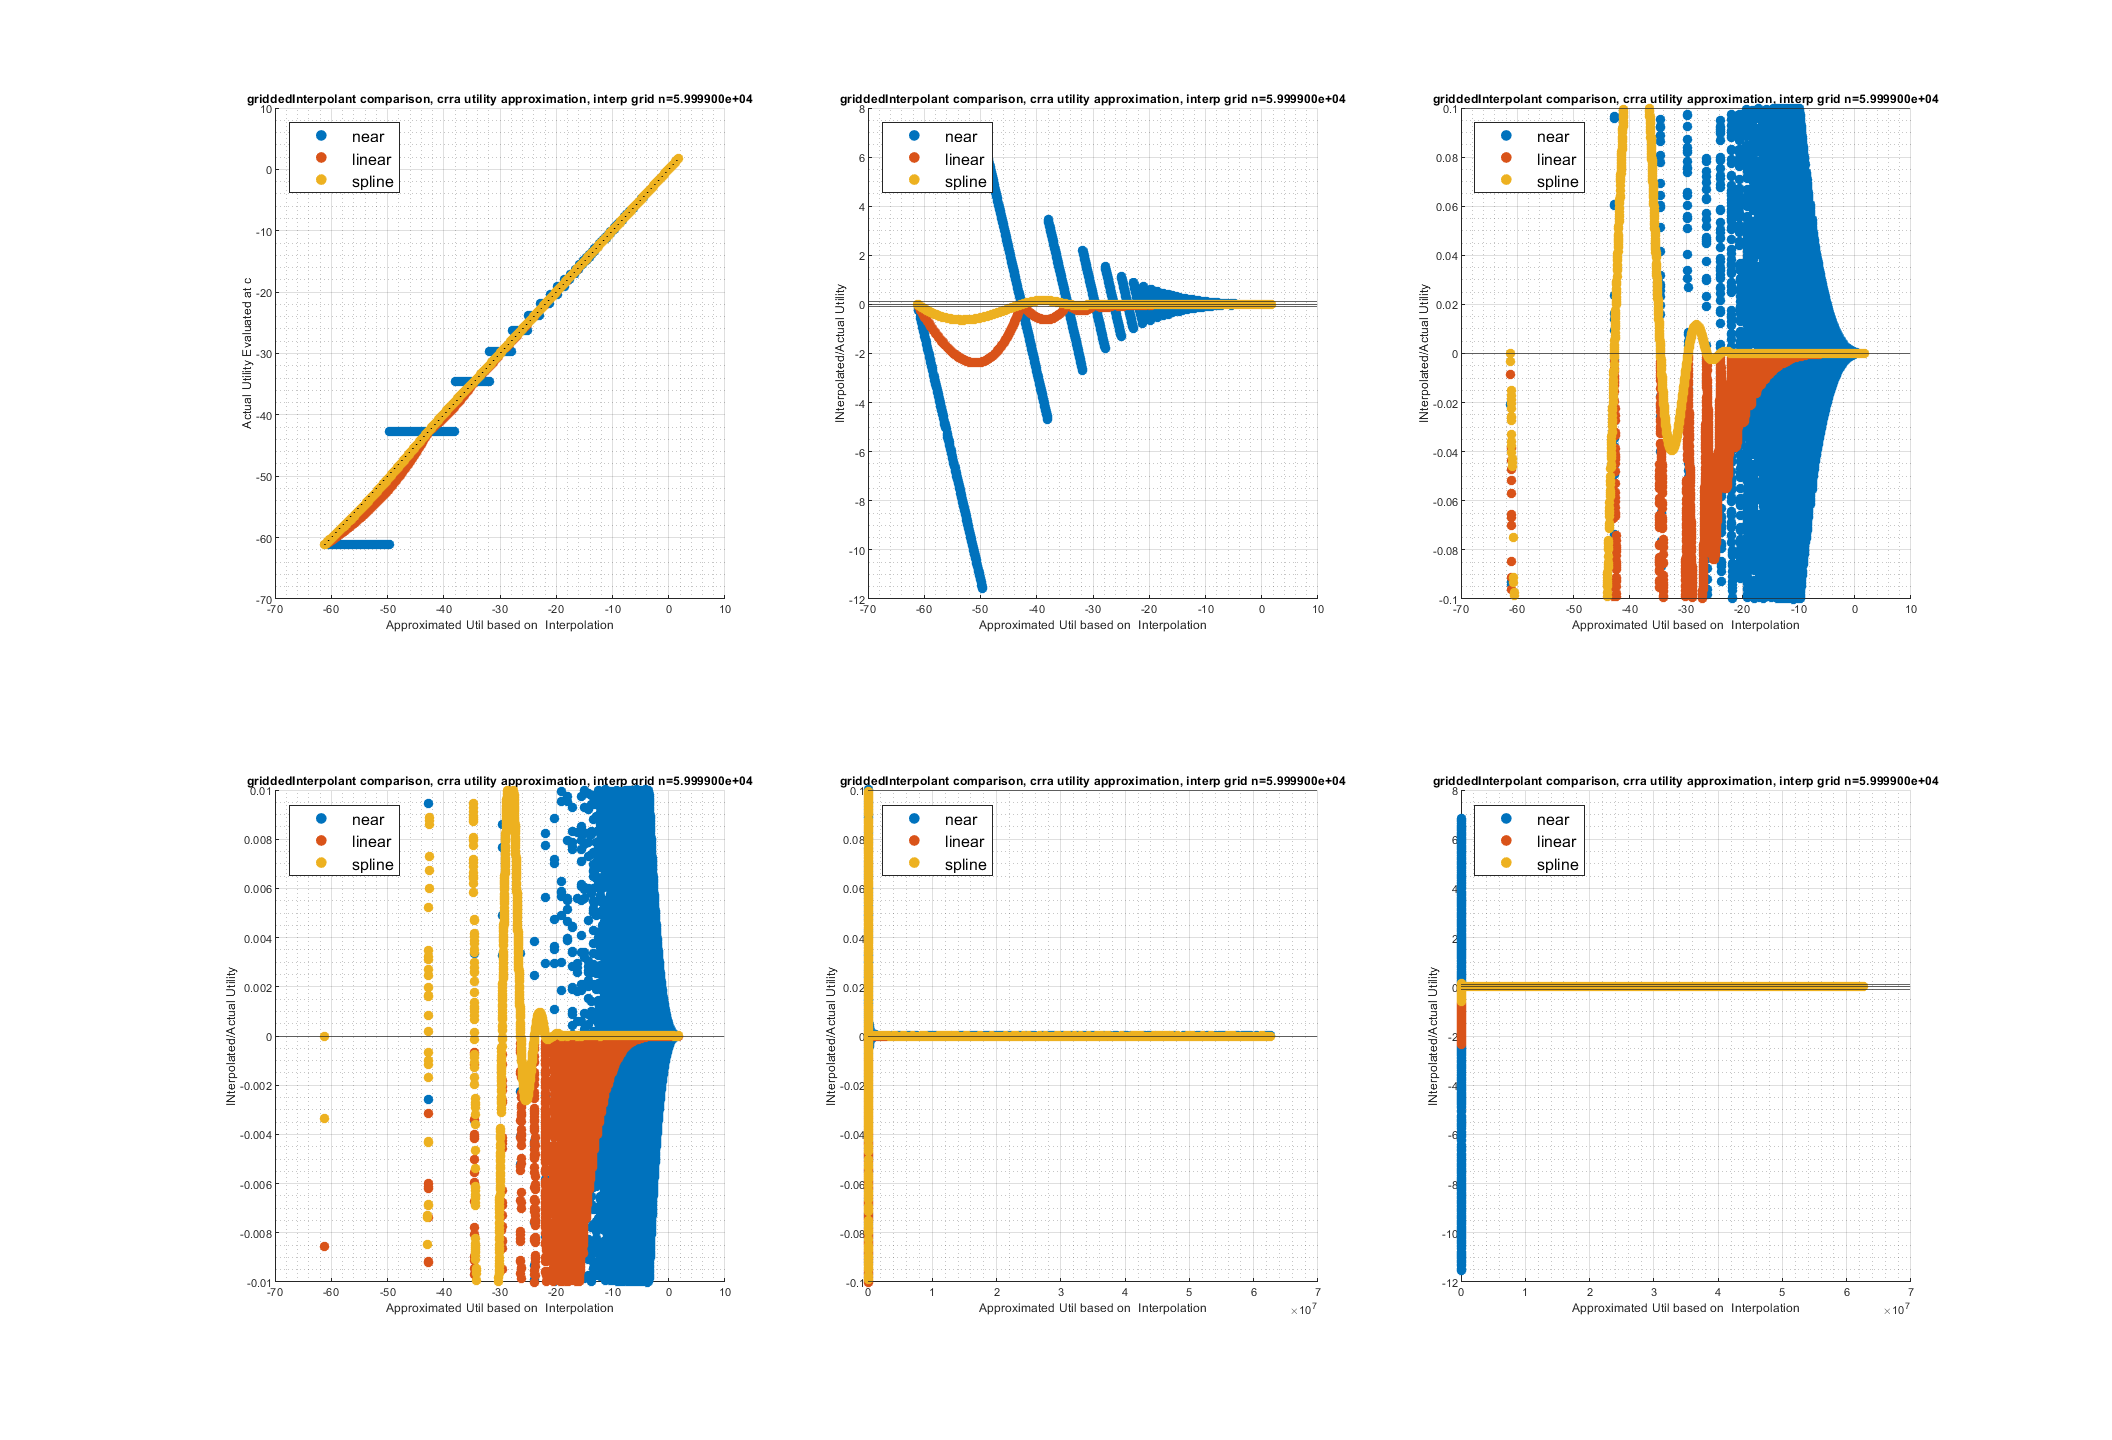

In [453]:
if (bl_show_fig)
    fl_fu_c_fixed = fu_c_fixed();
    ar_interp_gridded_near = fu_interp_gridded_near();
    ar_interp_gridded_linr = fu_interp_gridded_linr();
    ar_interp_gridded_spln = fu_interp_gridded_spln();

    figure('PaperPosition', [0 0 22 15]);

    for sub_j=1:1:6    
        subplot(2,3,sub_j)
        hold on;

        if (sub_j == 1) 
            ar_divide_by = 0;
        else
            ar_divide_by = fl_fu_c_fixed(:);
        end
        
        if (sub_j <= 4) 
            ar_x_vec = fl_fu_c_fixed(:);
        else
            ar_x_vec = 1:1:length(fl_fu_c_fixed(:));
        end

        g1 = scatter(ar_x_vec,  ar_interp_gridded_near(:)-ar_divide_by, 30, 'filled');
        g2 = scatter(ar_x_vec,  ar_interp_gridded_linr(:)-ar_divide_by, 30, 'filled');
        g3 = scatter(ar_x_vec,  ar_interp_gridded_spln(:)-ar_divide_by, 30, 'filled');
        legend([g1, g2, g3], {'near','linear','spline'}, 'Location','northwest',...
                'NumColumns',1,'FontSize',12,'TextColor','black');        

        if (sub_j == 1)             
            hline = refline([1 0]);
            hline.Color = 'k';
            hline.LineStyle = ':';
            hline.HandleVisibility = 'off';
            ylabel('Actual Utility Evaluated at c')
        else
            yline0 = yline(0);
            yline0.HandleVisibility = 'off';
            yline1 = yline(0.1);
            yline1.HandleVisibility = 'off';
            yline2 = yline(-0.1);
            yline2.HandleVisibility = 'off';
            ylabel('INterpolated/Actual Utility')

            if (sub_j == 3) 
                ylim([-0.1, 0.1])
            end
            if (sub_j == 4) 
                ylim([-0.01, 0.01])
            end
            if (sub_j == 5) 
                ylim([-0.1, 0.1])
            end
            if (sub_j == 6) 
            end            
        end

        grid on;
        grid minor;

        title(sprintf('griddedInterpolant comparison, crra utility approximation, interp grid n=%d', it_interp_points))

        xlabel('Approximated Util based on  Interpolation')
    end
end